# Lecture 20: Bioimaging II

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

Today, we'll wrap up our module on image processing with some more in-depth examples of how to analyze biological images. In particular, we'll look at _video_ data, arguably an important format for when you want to study some kind of system with a temporal component. By the end of this lecture, you should be able to

 - Understand how thresholding and segmentation are still relevant with video
 - Apply cross-entropy thresholding for adaptive segmentation
 - Read raw video formats into Python NumPy arrays using OpenCV
 - Use previous techniques to "preprocess" videos and identify potential objects
 - Implement a "centroid tracking" method to register and follow objects

## Part 1: Improved Segmentation

In the previous lecture, we discussed myriad techniques for processing images to try and find "objects" of interest in the images.

To a certain extent, all these approaches relied on the fundamental concept of a "filter", which entailed two components:

 1. The image itself (a large matrix), and
 2. a _convolutional filter_, or _kernel_ (a small matrix)

These two components are multiplied together element-wise and summed into one number, in a kind of "matrix dot-product" (with the exception of "non-linear" filters, like median or maximum).

From the concept of convolutions, we discussed several other strategies:

 - *Thresholding*, which can take the form of hard thresholds (pixel values) or more adaptive approaches (means or standard deviations)

 - *Edge detection*, which looks for so-called "image derivatives" that indicate edges, as implemented in the Canny Edge Detector, and taken to its logical conclusion with skeletonization

 - *Morphology*, such as erosion and dilation, which can smooth out rough edges, fill in pixel gaps, and eliminate small flecks of noise

 - *Segmentation*, such as Seeded Watershed, which uses the idea of a contour or elevation map being flooded with water from a set of initial "seeds"

Anything I'm forgetting?

Remember our good friend, heat shock protein 27?

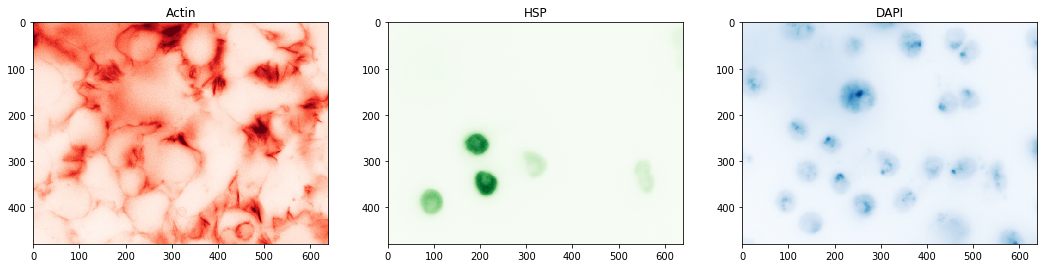

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as skio

img = skio.imread("ComputerVision/image1.png")
f = plt.figure(figsize = (18, 9))
f.add_subplot(1, 3, 1)
plt.title("Actin")
plt.imshow(img[:, :, 0], cmap = "Reds")
f.add_subplot(1, 3, 2)
plt.title("HSP")
plt.imshow(img[:, :, 1], cmap = "Greens")
f.add_subplot(1, 3, 3)
plt.title("DAPI")
plt.imshow(img[:, :, 2], cmap = "Blues")

We used a combination of strategies to try and identify the cells containing the most HSP27.

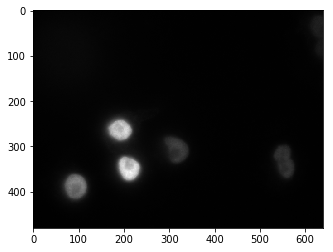

In [2]:
# HSP27 channel only
hsp = img[:, :, 1]
plt.imshow(hsp, cmap = "gray")

Remember our results? They weren't very good...

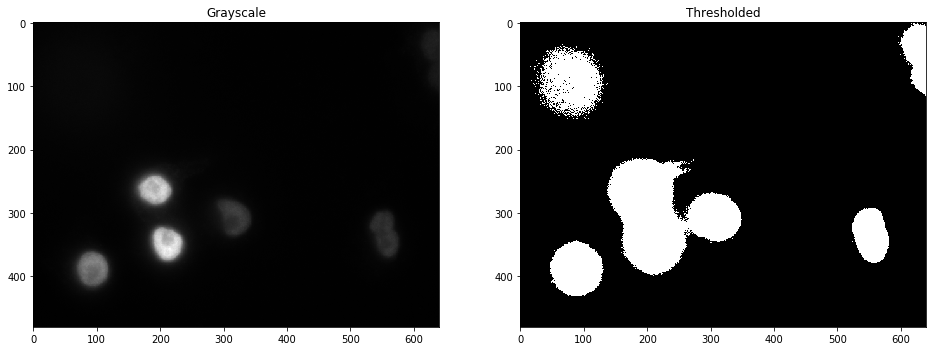

In [3]:
hsp_bin = hsp > hsp.mean()

f = plt.figure(figsize = (16, 8))
f.add_subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Thresholded")
plt.imshow(hsp_bin, cmap = "gray")

Let's try a different thresholding approach.

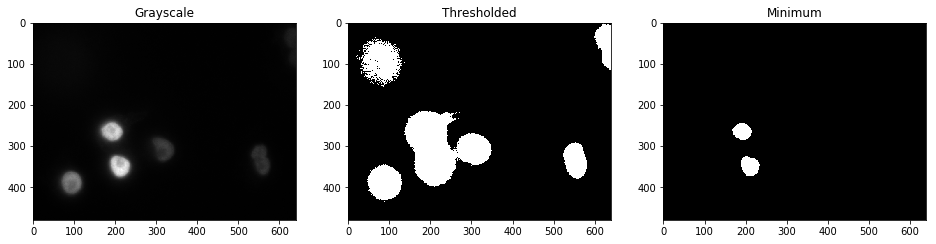

In [4]:
import skimage.filters as skfi

hsp_min = hsp > skfi.threshold_minimum(hsp)

f = plt.figure(figsize = (16, 8))
f.add_subplot(1, 3, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 3, 2)
plt.title("Thresholded")
plt.imshow(hsp_bin, cmap = "gray")
f.add_subplot(1, 3, 3)
plt.title("Minimum")
plt.imshow(hsp_min, cmap = "gray")

The "minimum" threshold takes advantage of the fact that a lot of images have histograms that are _bimodal_, and can therefore be sensitive to first-order statistics like mean. It repeatedly runs smoothing filters over the image until only two peaks remain in the histogram, then sets the threshold to be the minimum value between them.

![bimodal](Bioimaging2/bimodal.png)
http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html

In a similar vein, the Otsu threshold tries to find an "optimal" separation point between the two peaks in the pixel histogram: the point at which distance between pixels _in the same group_ is larger than the distance between pixels _in different groups_. 

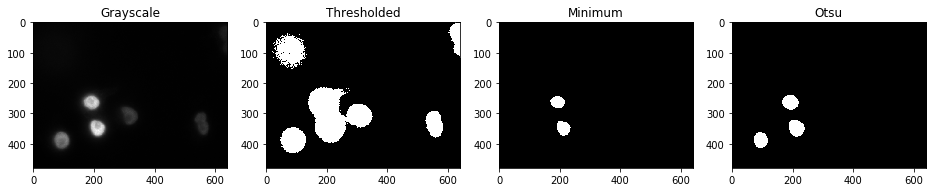

In [5]:
hsp_otsu = hsp > skfi.threshold_otsu(hsp)

f = plt.figure(figsize = (16, 8))
f.add_subplot(1, 4, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 4, 2)
plt.title("Thresholded")
plt.imshow(hsp_bin, cmap = "gray")
f.add_subplot(1, 4, 3)
plt.title("Minimum")
plt.imshow(hsp_min, cmap = "gray")
f.add_subplot(1, 4, 4)
plt.title("Otsu")
plt.imshow(hsp_otsu, cmap = "gray")

The Otsu filter in particular seems closest to what we want. Still, it's not perfect.

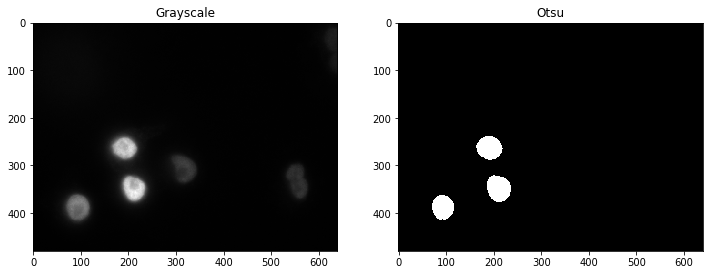

In [6]:
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Otsu")
plt.imshow(hsp_otsu, cmap = "gray")

One way to fix this could be to manually adjust the threshold that Otsu comes back with until it "looks right".

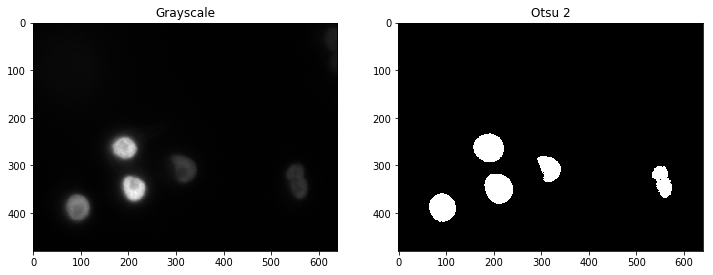

In [7]:
# The "- 40" makes the threshold *lower*
hsp_otsu2 = hsp > (skfi.threshold_otsu(hsp) - 40)
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Otsu 2")
plt.imshow(hsp_otsu2, cmap = "gray")

What are the strengths and weaknesses of this approach?

**Strengths**
 - A pixel threshold, so it's fast and simple
 - Semi-intelligent, aka _adaptive_
 - Major, major improvement in quality over the segmentation we had before

**Weaknesses**
 - Super-restrictive (only found 3 of 5 visible cells)
 - Some manual tweaking needed to get all 5 cells

One more method--the _minimum cross-entropy_ method, initially proposed in [Li _et al_ 1992](https://www.sciencedirect.com/science/article/abs/pii/003132039390115D) and improved upon in [Li _et al_ 1998](https://doi.org/10.1016/S0167-8655(98)00057-9) (was everyone here born by then?).

Put simply, this method attempts to minimize cross-entropy between the original image and its segmented (thresholded) version.

"Cross-entropy" is a fancy term for "uncertainty between two distributions" (those two distributions being: the original image, and the proposed segmented version for a given threshold value).

Basically, it's trying to find a way of thresholding the image in a way that most closely mimicks the image itself (i.e., you don't see any objects in the thresholded image that weren't there in the original image).

It works... pretty darn well:

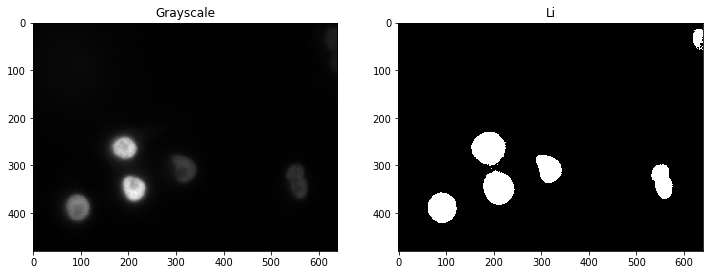

In [8]:
hsp_li = hsp > skfi.threshold_li(hsp)

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(hsp, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Li")
plt.imshow(hsp_li, cmap = "gray")

Once we have such a segmentation, recall how we can compute a lot of interesting properties about the regions--area, circumference, location, even major and minor axes.

This is great for fixed cells, or otherwise rigid objects. It certainly streamlines an experimental setup where most of the work is dedicated to counting cells.

But what about live-cell imaging? What happens when we want to _follow_ these objects, studying how they move? Or possibly even study how cells _change as they move_?

## Part 2: Tracking Objects

There's an entire area of computer vision dedicated exclusively to the problem of _tracking_. It's a **really hard problem**, and often boils down to domain-specific answers (i.e., there's no single Algorithm To Track Them All).

![tracking](Bioimaging2/tracking.png)

https://eds-uga.github.io/cbio4835-fa18/slides/Bioimaging2/tracking.gif

(Source: https://www.pyimagesearch.com/2018/10/29/multi-object-tracking-with-dlib/ )

Intuitively, though: using the concepts of the ideas we've discussed so far, how would you build a hypothetical object tracking module?

**Step 1**: Identify the objects in a given frame at time $t$ (like we just did with the Li threshold).

**Step 2**: Compute some _unique feature_ of each object--can you think of one?

**Step 3**: Repeat Steps 1 and 2 on the next frame at time $t + 1$, and try to find the unique feature of each object you found in frame $t$ now in frame $t + 1$ (this is known as _alignment_).

**Step 4**: Make frame $t + 1$ the new frame $t$, and go back to Step 1.

### _Toxoplasma gondii_

_T. gondii_ is a parasitic protozoan, and one of the most successful on the planet.

![tgondii](Bioimaging2/tgondii.png)

It's estimated to infect over a third of the world's population. Most of that is a latent form, held in check by healthy immune systems. But there is a risk of flare-up, and disseminated toxoplasmosis does tend to affect infants, elderly, and immunocompromised individuals.

The motility of _T. gondii_ is directly linked to its virulence, so understanding how and why _T. gondii_ move as they do could be key to developing targeted therapies.

In [9]:
from IPython.display import Video
Video("Bioimaging2/tgondii.mov")

### Reading video files

As with images, it's still a lot like reading text files in Python.

In [10]:
import cv2

frames = []
cap = cv2.VideoCapture("Bioimaging2/tgondii.avi")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gframe)

In [11]:
print("Read in {} frames".format(len(frames)))
print("Each frame has height {} and width {}".format(frames[0].shape[1], frames[0].shape[0]))

Read in 900 frames
Each frame has height 600 and width 600


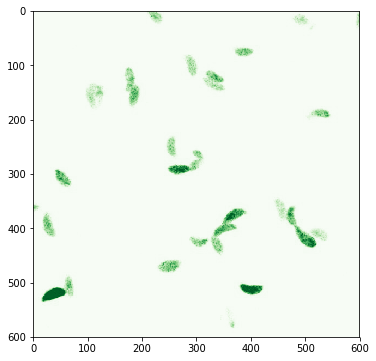

In [12]:
plt.figure(figsize = (12, 6))
plt.imshow(frames[0], cmap = "Greens")

Another way, which I recommend, is to use the `imageio` package--a lightweight Python library for reading and writing images and video (of MANY different formats!).

In [13]:
import imageio

cap = imageio.get_reader("Bioimaging2/tgondii.avi")
frames = []
for frame in cap:
    frames.append(frame)

In [14]:
print("Read in {} frames".format(len(frames)))
print("Each frame has height {} and width {}".format(frames[0].shape[1], frames[0].shape[0]))

Read in 900 frames
Each frame has height 600 and width 600


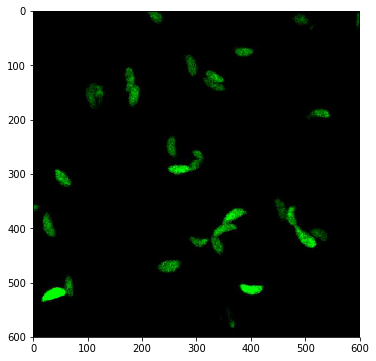

In [15]:
plt.figure(figsize = (12, 6))
plt.imshow(frames[0])

The only downside of `imageio` is the frames are read as RGB format:

In [16]:
print(frames[0].shape)

(600, 600, 3)


So these have to be converted to grayscale:

In [17]:
import skimage.color as skc
import skimage
import numpy as np

gray_frames = []
for frame in frames:
    gray_frame = skc.rgb2gray(frame)  # convert to grayscale
    new_frame = skimage.img_as_ubyte(gray_frame) # convert to 0-255
    gray_frames.append(new_frame)
volume = np.array(gray_frames)

/opt/python/envs/cbio/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [18]:
print(volume.shape)

(900, 600, 600)


### Cross-entropy over frames

Your first thought for tracking the _T. gondii_ parasites might (rightly!) be: let's just do the threshold we've been using on each frame, then try to link up the objects?

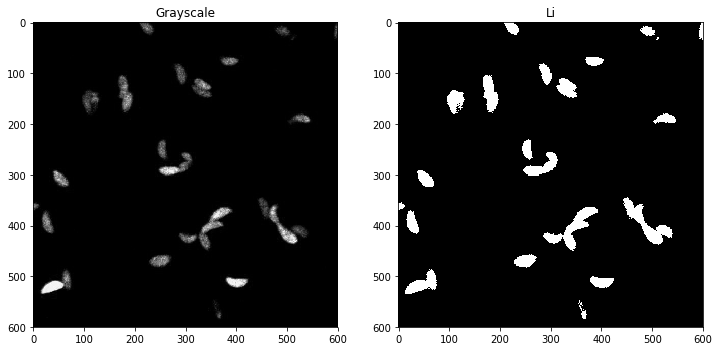

In [19]:
vol_bin = volume[0] > skfi.threshold_li(volume[0])

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(volume[0], cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Li")
plt.imshow(vol_bin, cmap = "gray")

In [20]:
bin_volume = np.array([v > skfi.threshold_li(v) for v in volume])

So... what's next?

We need to compute some kind of unique feature for each object, something that we can track between frames. Any ideas?

**Centroid!**

![centroids](Bioimaging2/centroids.png)

(Source: https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/ )

We can do this in a handful of steps (similar to what we wrote earlier):

**Step 1**: Find the objects and compute their centroids (Steps 1 and 2 from before).

**Step 2**: Compute _Euclidean distance_ between each centroid in the _current_ frame (at time $t + 1$) and those from the _previous_ frame (at time $t$).

![alignment](Bioimaging2/alignment.png)

(Source: https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/ )

**Step 3**: Update our records of each object in terms of their locations.

![update](Bioimaging2/update.png)

(Source: https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/ )

**Step 4**: Register all the objects we're tracking (basically "have a mechanism to keep track of them"; can you think of one??).

![register](Bioimaging2/register.png)

(Source: https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/ )

**Step 5**: _De_-register any objects we've lost track of (when would this happen??).

"But," you ask, "how do we compute centroids and bounding boxes from the binary mask we saw earlier?"

Recall two fancy functions from scikit-image:

 - `skimage.measure.label`: takes a binary image and identifies all the objects (connected pixels) in the image

 - `skimage.measure.regionprops`: computes spatial properties of all the objects in an image, including (but not limited to) the **centroid** of each object and its **bounding box**

Let's give it a shot, shall we?

In [21]:
# First, compute the objects using the "label" function.
import skimage.measure as skms
objects, n_obj = skms.label(bin_volume[0], return_num = True)

Found 38 objects in frame 1.


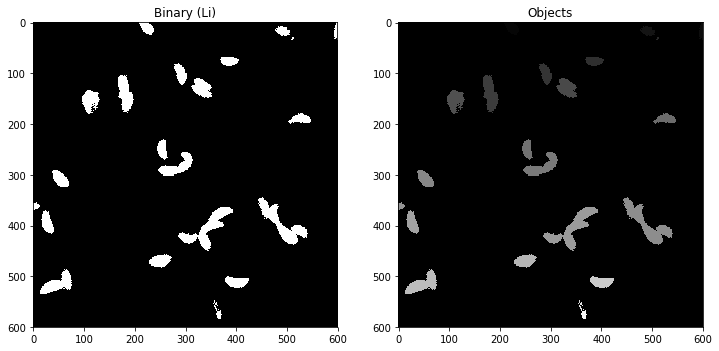

In [22]:
print("Found {} objects in frame 1.".format(n_obj))

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Binary (Li)")
plt.imshow(bin_volume[0], cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Objects")
plt.imshow(objects, cmap = "gray")

Now, let's compute the bounding boxes and centroids for each object.

In [23]:
props = skms.regionprops(objects)
boxes_and_centroids = np.copy(objects)
t = objects.max() + 1
for obj in props:
    # Recall: http://scikit-image.org/docs/dev/api/skimage.measure.html#regionprops
    min_row, min_col, max_row, max_col = obj["bbox"]
    boxes_and_centroids[min_row:max_row + 1, min_col:min_col + 2] = t
    boxes_and_centroids[min_row:max_row + 1, max_col - 2:max_col] = t
    boxes_and_centroids[min_row:min_row + 2, min_col:max_col + 1] = t
    boxes_and_centroids[max_row - 2:max_row, min_col:max_col + 1] = t

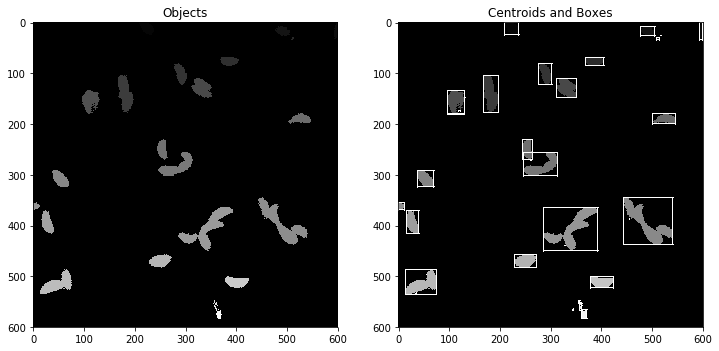

In [24]:
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Objects")
plt.imshow(objects, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Centroids and Boxes")
plt.imshow(boxes_and_centroids, cmap = "gray")

You can probably already see part of the problem: **multiple objects have been grouped together**.

That's a common problem, and not one that is easily solved, unfortunately.

For now, we'll continue and see if we can get a decent tracking method working.

Let's look at the 10th frame (as a way of seeing a bit more motion than we would with the 2nd frame).

In [25]:
objects2, n_obj2 = skms.label(bin_volume[10], return_num = True)
print("Found {} objects in frame 10 (compared to {} in frame 1).".format(n_obj2, n_obj))

Found 36 objects in frame 10 (compared to 38 in frame 1).


In [26]:
props2 = skms.regionprops(objects2)
boxes_and_centroids2 = np.copy(objects2)
t = objects2.max() + 1
for obj in props2:
    min_row, min_col, max_row, max_col = obj["bbox"]
    boxes_and_centroids2[min_row:max_row + 1, min_col:min_col + 2] = t
    boxes_and_centroids2[min_row:max_row + 1, max_col - 2:max_col] = t
    boxes_and_centroids2[min_row:min_row + 2, min_col:max_col + 1] = t
    boxes_and_centroids2[max_row - 2:max_row, min_col:max_col + 1] = t

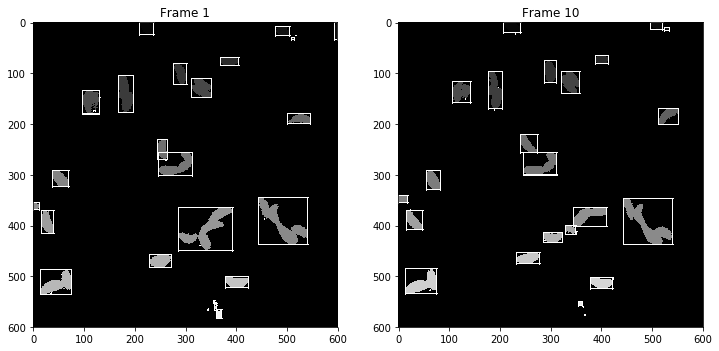

In [27]:
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.title("Frame 1")
plt.imshow(boxes_and_centroids, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.title("Frame 10")
plt.imshow(boxes_and_centroids2, cmap = "gray")

Now, the critical element: drawing equivalences between centroids of each object.

Hopefully the intuition is fairly straightforward:

 - For a given centroid in frame 10, measure the distance between it and all the centroids _in frame 1_.

 - Choose the centroid _in frame 1_ with the smallest distance.

 - Link up those two centroids between frame 1 and frame 10, and now consider them _the same object_.

What are the possible complications?

 - **Too few / too many objects**. Like we saw in the example, the number of objects we found went from 38 in frame 1 to 36 in frame 10. Two objects vanished! It could have just as easily gone the other way, too: more objects in future frames. This can happen easily given how our method of finding objects groups objects together that are touching.

 - **Misalignment of objects**. Imagine a situation where you align one object between two frames, but that object just happened to be one that _appeared_ in the future frame! This could set off a "misalignment cascade" where all the other objects are misaligned. 

 - **Objects that aren't objects**. Some of the "objects" in our images looked like noise--they were just tiny little things that probably shouldn't be objects in the first place.

In [28]:
Video("Bioimaging2/tracking.mov")

In practice, most tracking algorithms use these basic principles, with a few additions:

 - **Look at tracking history to "predict" future.** If you're tracking a soccer or football player, you have an intuitive sense of _momentum_ that intrinsically limits where the player could move in the next time step. We can apply the same principle to tracking to help narrow our search space for the object(s) in future frames and potentially distinguish between multiple object candidates.

 - **Perform segmentation and tracking simultaneously.** This may seem like more work, but it dovetails off the idea of keeping track of history. If you know the direction _and the shape_ of the object you were tracking before, you have an idea of both where it could be _and what it looks like_. This can really help to distinguish between multiple overlapped objects.

Regardless, it's still the same idea:
 1. Find the objects
 2. Represent each object with some unique quantitative features
 3. Track those features over time

## Administrivia

 - How is the project going (for those of you doing it)?
   - You should have received feedback on your proposals (grades are on eLC, spoiler alert everyone got 100s)
   - Presentations are **Tues/Thurs April 21/23**. 
   - Final write-ups will be due by **11:59pm on April 30** (the day of our final exam)

 - Last homework assignment is due next Thursday!

## Additional Resources

 1. "Simple object tracking with OpenCV", https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
 2. "Multi-object tracking with dlib", https://www.pyimagesearch.com/2018/10/29/multi-object-tracking-with-dlib/ (lots of great links here to other tracking tutorials in OpenCV)
 3. `imageio`, https://imageio.github.io/ 